# Assignment-2
# ROLL NO : 18NA10001
# NAME: Agontuk Biswas


#IMPORTING NECESSARY LIBRARIES


In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from nltk.corpus import stopwords 
from collections import Counter
import string
import re
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


# LOAD AND VISUALIZE DATASET


In [3]:
df = pd.read_csv('IMDB Dataset.csv')
X = df.iloc[ : , 0].values
y = df.iloc[ : , 1].values
print(X[:20])
print()
print(y[:20])

["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the f

# TEST TRAIN SPLIT


In [4]:
X,y = df['review'].values,df['sentiment'].values
x_train,x_test,y_train,y_test = train_test_split(X,y,stratify=y)
print(f'shape of train data is {x_train.shape}')
print(f'shape of test data is {x_test.shape}')

shape of train data is (37500,)
shape of test data is (12500,)


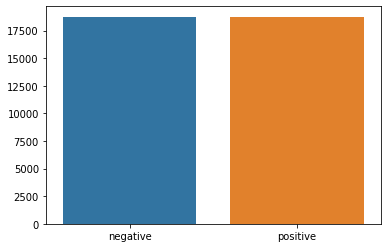

In [5]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

# DATA PREPROCESSING AND TOCKENIZATION


In [6]:
def preprocess_string(s):
    # Remove all non-word characters (everything except numbers and letters)
    s = re.sub(r"[^\w\s]", '', s)
    # Replace all runs of whitespaces with no space
    s = re.sub(r"\s+", '', s)
    # replace digits with no space
    s = re.sub(r"\d", '', s)

    return s

def tockenize(x_train,y_train,x_val,y_val):
    word_list = []

    stop_words = set(stopwords.words('english')) 
    for sent in x_train:
        for word in sent.lower().split():
            word = preprocess_string(word)
            if word not in stop_words and word != '':
                word_list.append(word)
  
    corpus = Counter(word_list)
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:1000]
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}
    
    final_list_train,final_list_test = [],[]
    for sent in x_train:
            final_list_train.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                     if preprocess_string(word) in onehot_dict.keys()])
    for sent in x_val:
            final_list_test.append([onehot_dict[preprocess_string(word)] for word in sent.lower().split() 
                                    if preprocess_string(word) in onehot_dict.keys()])
            
    encoded_train = [1 if label =='positive' else 0 for label in y_train]  
    encoded_test = [1 if label =='positive' else 0 for label in y_val] 
    return np.array(final_list_train), np.array(encoded_train),np.array(final_list_test), np.array(encoded_test),onehot_dict

In [7]:
import nltk
nltk.download('stopwords')
x_train,y_train,x_test,y_test,vocab = tockenize(x_train,y_train,x_test,y_test)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [8]:
print(f'Length of vocabulary is {len(vocab)}')

Length of vocabulary is 1000


# PADDING

In [9]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [10]:
x_train_pad = padding_(x_train,500)
x_test_pad = padding_(x_test,500)

# Batching and loading as tensor

In [11]:
train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(y_test))

batch_size = 50

#shuffling the data
train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size)

In [12]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) 
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([50, 500])
Sample input: 
 tensor([[  0,   0,   0,  ..., 340, 224, 443],
        [  0,   0,   0,  ...,   1, 321,   9],
        [  0,   0,   0,  ..., 308,   3, 941],
        ...,
        [  0,   0,   0,  ...,  85,   1, 186],
        [  0,   0,   0,  ..., 324,   1, 657],
        [  0,   0,   0,  ...,  15,  52, 988]])
Sample input: 
 tensor([1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1,
        0, 1])


# MODEL DESIGNING

In [13]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()
 
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
 
        self.no_layers = no_layers
        self.vocab_size = vocab_size
    
        self.embedding = nn.Embedding(vocab_size, embedding_dim)  
        
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,num_layers=no_layers, batch_first=True)
        
        self.dropout = nn.Dropout(0.3)
    
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()
        
    def forward(self,x,hidden):
        batch_size = x.size(0)

        embeds = self.embedding(x)  
        
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim) 
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] 
        
        return sig_out, hidden
        
        
        
    def init_hidden(self, batch_size):
        h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden


In [14]:
no_layers = 2
vocab_size = len(vocab) + 1 
embedding_dim = 64
output_dim = 1
hidden_dim = 256


model = SentimentRNN(no_layers,vocab_size,hidden_dim,embedding_dim,drop_prob=0.5)

model.to(device)

print(model)

SentimentRNN(
  (embedding): Embedding(1001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


# TRAINING

In [15]:
lr=0.001

criterion = nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()
lr=0.001

criterion = nn.BCELoss() #using binary cross entropy loss

optimizer = torch.optim.Adam(model.parameters(), lr=lr) # using adam optimizer

def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()

In [16]:
clip = 5
epochs = 10 
valid_loss_min = np.Inf
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train() 
    h = model.init_hidden(batch_size)
    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)   
        h = tuple([each.data for each in h])
        
        model.zero_grad()
        output,h = model(inputs,h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        train_losses.append(loss.item())
        accuracy = acc(output,labels)
        train_acc += accuracy
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
        
    val_h = model.init_hidden(batch_size)
    val_losses = []
    val_acc = 0.0
    model.eval()
    for inputs, labels in valid_loader:
            val_h = tuple([each.data for each in val_h])

            inputs, labels = inputs.to(device), labels.to(device)

            output, val_h = model(inputs, val_h)
            val_loss = criterion(output.squeeze(), labels.float())

            val_losses.append(val_loss.item())
            
            accuracy = acc(output,labels)
            val_acc += accuracy
            
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)
    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    if epoch_val_loss <= valid_loss_min:
        valid_loss_min = epoch_val_loss
    print(25*'==')

Epoch 1
train_loss : 0.5428968326250712 val_loss : 0.44610032135248184
train_accuracy : 72.86933333333333 val_accuracy : 80.128
Epoch 2
train_loss : 0.39455219749609627 val_loss : 0.37348747098445895
train_accuracy : 83.096 val_accuracy : 83.672
Epoch 3
train_loss : 0.333969539831082 val_loss : 0.34009471541643144
train_accuracy : 85.78933333333333 val_accuracy : 85.008
Epoch 4
train_loss : 0.30166585155328113 val_loss : 0.3614940296411514
train_accuracy : 87.37333333333333 val_accuracy : 84.768
Epoch 5
train_loss : 0.274516732742389 val_loss : 0.343097428381443
train_accuracy : 88.66666666666667 val_accuracy : 85.032
Epoch 6
train_loss : 0.23924939569830894 val_loss : 0.36301253125071525
train_accuracy : 90.33333333333333 val_accuracy : 85.24000000000001
Epoch 7
train_loss : 0.18329610626896223 val_loss : 0.3990811342000961
train_accuracy : 92.888 val_accuracy : 85.2
Epoch 8
train_loss : 0.12213299702356259 val_loss : 0.4951462808251381
train_accuracy : 95.376 val_accuracy : 84.352
Ep

# ACCURACY AND LOSS PLOTS

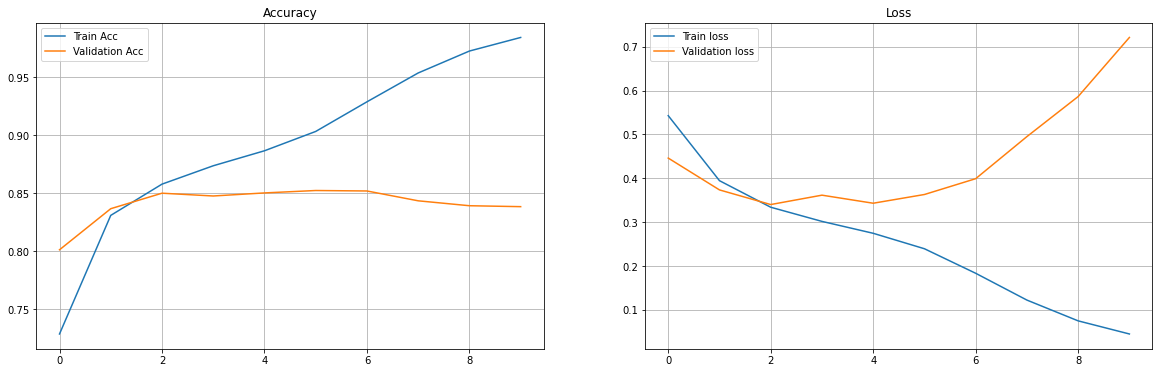

In [17]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 2, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()
    
plt.subplot(1, 2, 2)
plt.plot(epoch_tr_loss, label='Train loss')
plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
plt.legend()
plt.grid()

plt.show()

# INFERENCE

In [18]:
def predict_text(text):
        word_seq = np.array([vocab[preprocess_string(word)] for word in text.split() 
                         if preprocess_string(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

In [19]:
index = 25
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'Predicted sentiment is {status} with a probability of {pro}')

The Karen Carpenter Story shows a little more about singer Karen Carpenter's complex life. Though it fails in giving accurate facts, and details.<br /><br />Cynthia Gibb (portrays Karen) was not a fine election. She is a good actress , but plays a very naive and sort of dumb Karen Carpenter. I think that the role needed a stronger character. Someone with a stronger personality.<br /><br />Louise Fletcher role as Agnes Carpenter is terrific, she does a great job as Karen's mother.<br /><br />It has great songs, which could have been included in a soundtrack album. Unfortunately they weren't, though this movie was on the top of the ratings in USA and other several countries
Actual sentiment is  : positive
Predicted sentiment is positive with a probability of 0.9997573494911194


In [20]:
index = 32
print(df['review'][index])
print('='*70)
print(f'Actual sentiment is  : {df["sentiment"][index]}')
print('='*70)
pro = predict_text(df['review'][index])
status = "positive" if pro > 0.5 else "negative"
pro = (1 - pro) if status == "negative" else pro
print(f'predicted sentiment is {status} with a probability of {pro}')

My first exposure to the Templarios & not a good one. I was excited to find this title among the offerings from Anchor Bay Video, which has brought us other cult classics such as "Spider Baby". The print quality is excellent, but this alone can't hide the fact that the film is deadly dull. There's a thrilling opening sequence in which the villagers exact a terrible revenge on the Templars (& set the whole thing in motion), but everything else in the movie is slow, ponderous &, ultimately, unfulfilling. Adding insult to injury: the movie was dubbed, not subtitled, as promised on the video jacket.
Actual sentiment is  : negative
predicted sentiment is negative with a probability of 0.9891394330188632
